In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pydot

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/431/Emotion_final.csv')

In [ ]:
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
df['Emotion'] = df['Emotion'].astype('category')

AttributeError: ignored

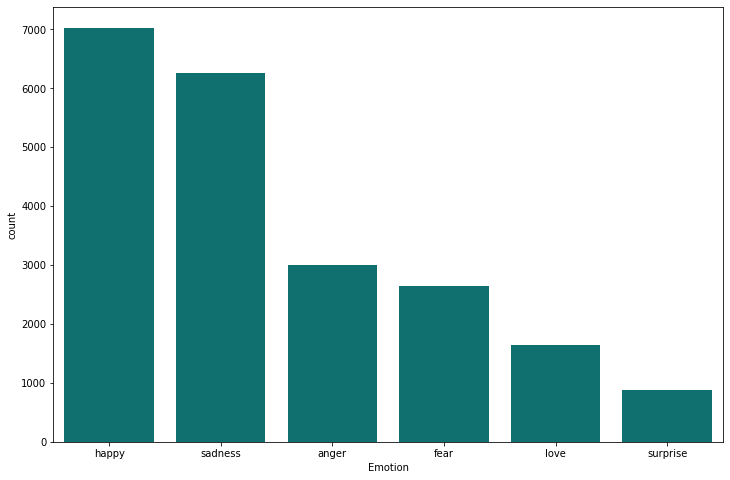

In [ ]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import seaborn as sns

sns.axes_style("white")


def bar_plot(dataframe, column):
    prop = FontProperties(fname='kalpurush.ttf', size=20)
    _, ax = plt.subplots(figsize=(12, 8))
    sns.countplot(data=dataframe, x=column,
                  order=dataframe[column].value_counts().index, color='teal')
    ax.bar_label(ax.containers[0])
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=prop)
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Emotion Classes by count')
    plt.savefig('emotion_count', dpi=100, bbox_inches='tight')


bar_plot(df, 'Emotion')

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string



def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

In [ ]:
df.dropna(axis = 0, how ='any',inplace=True) 
df['Num_words_text'] = df['Text'].apply(lambda x:len(str(x).split())) 
mask = df['Num_words_text'] >2
df = df[mask]
print('-------Train data--------')
print(df['Emotion'].value_counts())
print(len(df))
print('-------------------------')
max_train_sentence_length  = df['Num_words_text'].max()


df['Text'] = df['Text'].apply(remove_emoji)
df['Text'] = df['Text'].apply(remove_url)
df['Text'] = df['Text'].apply(clean_text)

-------Train data--------
happy       7027
sadness     6264
anger       2990
fear        2649
love        1641
surprise     879
Name: Emotion, dtype: int64
21450
-------------------------


In [ ]:
df = df[df.groupby('Emotion')['Emotion'].transform('count') > 2000].reset_index()
df["Emotion"] = df["Emotion"].cat.remove_unused_categories()

AttributeError: ignored

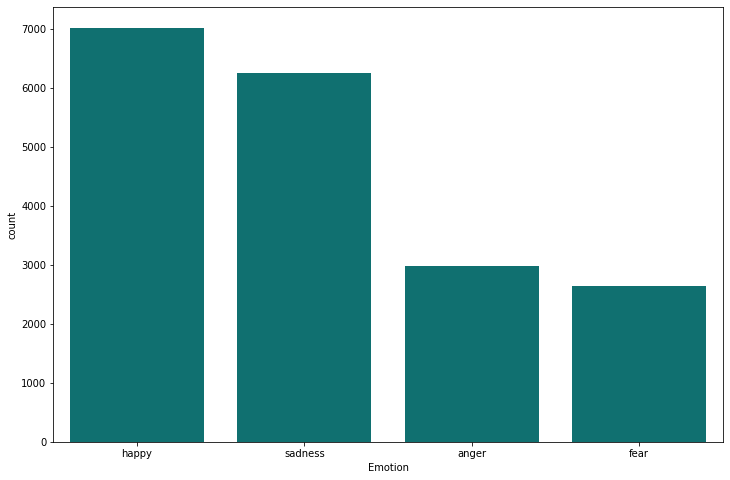

In [ ]:
bar_plot(df, 'Emotion')

In [ ]:
df.dropna(axis = 0, how ='any',inplace=True) 
df['Num_words_text'] = df['Text'].apply(lambda x:len(str(x).split())) 
mask = df['Num_words_text'] >2
df = df[mask]
print('-------Train data--------')
print(df['Emotion'].value_counts())
print(len(df))
print('-------------------------')
max_train_sentence_length  = df['Num_words_text'].max()


df['Text'] = df['Text'].apply(remove_emoji)
df['Text'] = df['Text'].apply(remove_url)
df['Text'] = df['Text'].apply(clean_text)

-------Train data--------
happy      6989
sadness    6215
anger      2963
fear       2629
Name: Emotion, dtype: int64
18796
-------------------------


### Tokenizing Data

Tokenizing the emotion using keras **Tokenizer()** before running machine learning models

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text'])
X = tokenizer.texts_to_sequences(df['Text'])

Plotting word histogram to determine what length would be suitable for padding.

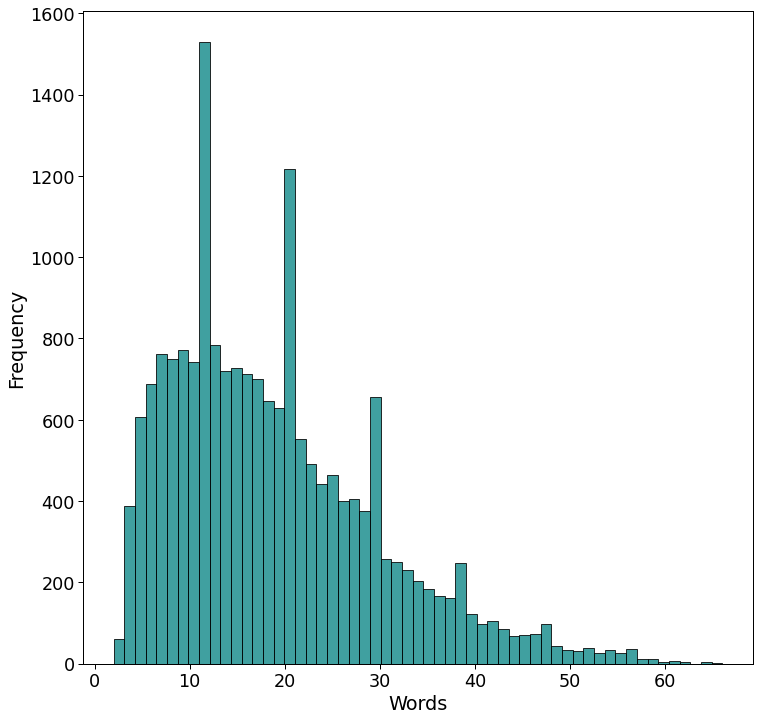

In [ ]:
lengths = pd.Series([len(x) for x in X])

with sns.plotting_context("paper", font_scale=2):
    plt.figure(figsize=(12, 12))
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    sns.histplot(lengths, color='teal')
    plt.savefig('wordhist', dpi=100, bbox_inches='tight')


From the graph, we are taking max len as 1200


In [ ]:
max_len = 1600
X = pad_sequences(X, maxlen=max_len)
y = df['Emotion'].cat.codes.ravel()
y = y.reshape(-1, 1)

## Model

In this notebook we run macine learing models such as:

- LogisticRegression
- KNeighborsClassifier
- SupprotVectorClassifier
- XGBClassifier
- AdaBoostClassifier

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random


def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


seed = 4
vocab_size = 39970
embed_size = 100

Splitting the dataset to 80:20 train:test ratio

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=seed, stratify=y)

set_seed(seed)

### Logistic Regression

Using **GridSearchCV()** to find best parameters for **LogisticRegression**

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression())
])
param_grid = {'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'clf__C': [100, 10, 1.0, 0.1, 0.01], 'clf__max_iter': [10000]}
gs = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train, y_train.ravel())
gs.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: user 31.1 s, sys: 2.68 s, total: 33.8 s
Wall time: 14min 19s


{'clf__C': 0.1, 'clf__max_iter': 10000, 'clf__solver': 'newton-cg'}

Training LogisticRegression with best parameters and evaluating test set score

In [ ]:
log_reg = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(C=0.01, solver='liblinear', max_iter=10000))
])
log_reg.fit(X_train, y_train.ravel())
log_reg_y = log_reg.predict(X_test)
log_reg.score(X_test, y_test)

0.3707446808510638

### K Nearest Neighbors Classifier

Using **GridSearchCV()** to find best parameters for **KNeighborsClassifier**

In [ ]:
%%time
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier()
param_grid = {'n_neighbors':  [1, 2, 3, 4],
              'p': [1, 2], 'leaf_size': [10, 20, 30, 40]}
gs = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train.ravel())
print(gs.best_params_)

{'leaf_size': 10, 'n_neighbors': 4, 'p': 2}
CPU times: user 18.3 s, sys: 2.64 s, total: 20.9 s
Wall time: 51min 41s


In [ ]:
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(n_neighbors=4, p=1, leaf_size=10)
knn = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
knn.fit(X_train, y_train.ravel())
knn_y = knn.predict(X_test)
knn.score(X_test, y_test)

0.3079787234042553

Support Vector Machine
Using GridSearchCV() to find best parameters for SVC

In [ ]:
%%time
from sklearn.svm import SVC


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


clf = SVC()
param_grid = {'C':  [0.1, .5, 1.0],
              'gamma': ['scale', .1, .5]}
gs = GridSearchCV(clf, param_grid, cv=5,
                  scoring='accuracy', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train.ravel())
print(gs.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'C': 0.5, 'gamma': 'scale'}
CPU times: user 8min 38s, sys: 12.8 s, total: 8min 51s
Wall time: 4h 37min 42s


In [ ]:
svc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', SVC(C=1, gamma='scale'))
]) 
svc.fit(X_train, y_train.ravel())
svc_y = svc.predict(X_test)
svc.score(X_test, y_test.ravel())

0.3756599788806758

Extreme Gradient Boosting

In [ ]:
%%time
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.svm import SVC


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression



xgbc = Pipeline([('clf', XGBClassifier(learning_rate=0.01,
                                       colsample_bytree=0.4,
                                       subsample=0.8,
                                       n_estimators=1000,
                                       reg_alpha=0.3,
                                       max_depth=4,
                                       gamma=10))])

xgbc.fit(X_train, y_train.ravel())
xgbc_y = xgbc.predict(X_test)
xgbc.score(X_test, y_test)

CPU times: user 24min 36s, sys: 2.34 s, total: 24min 39s
Wall time: 24min 45s


0.39836325237592396

AdaBoost
Using GridSearchCV() to find best parameters for AdaBoostClassifier

In [ ]:
%%time
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier()
param_grid = {"n_estimators": [10, 50, 100,
                               500, 100], "learning_rate": [1, .1, .01]}
gs = GridSearchCV(adb, param_grid, cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train, y_train.ravel())
gs.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: user 4min 17s, sys: 2.96 s, total: 4min 20s
Wall time: 1h 8min 24s


{'learning_rate': 0.1, 'n_estimators': 500}

In [ ]:
adb = AdaBoostClassifier(learning_rate=.1, n_estimators=500)
adb.fit(X_train, y_train.ravel())
adb_y = adb.predict(X_test)
adb.score(X_test, y_test)

0.4123548046462513

### One hot Encoding

One hot encoding the target values for our CNN model

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.utils import to_categorical

y_enc = to_categorical(y)
num_class = y_enc.shape[1]


X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=.2, random_state=seed, stratify=y)

In [ ]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.7 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Embedding, GlobalAvgPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa

f1_weighted = tfa.metrics.F1Score(num_class, 'weighted')


def get_cnn():
    model = Sequential()
    model.add(Embedding(vocab_size+2, embed_size,
              input_length=max_len, trainable=True))
    model.add(Conv1D(128, 3, padding='same'))
    model.add(GlobalAvgPool1D())
    model.add(Dense(num_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy', f1_weighted])
    return model

### K-Fold CV

Using $k=10$ folds for training and evaluating our model performance

In [ ]:
%%time
folds = StratifiedKFold(3, shuffle=True, random_state=seed).split(
    X_train, y_train.argmax(1))

set_seed(seed)
scores = []


for i, (train, valid) in enumerate(folds):
    print(f'{"="*150}\nIteration {1+i}:')
    model = get_cnn()
    early_stop = EarlyStopping(patience=3)
    checkpoint = ModelCheckpoint(
        f'model_fold{1+i}.h5', save_best_only=True)
    model.fit(X_train[train], y_train[train], validation_data=(
        X_train[valid], y_train[valid]), epochs=100, batch_size=1024, callbacks=[early_stop, checkpoint])

Iteration 1:
Epoch 1/100
10/10 [==============================] - 6s 517ms/step - loss: 1.3301 - accuracy: 0.3493 - f1_score: 0.2110 - val_loss: 1.3062 - val_accuracy: 0.3710 - val_f1_score: 0.2008
Epoch 2/100
10/10 [==============================] - 3s 288ms/step - loss: 1.3066 - accuracy: 0.3712 - f1_score: 0.2010 - val_loss: 1.3010 - val_accuracy: 0.3710 - val_f1_score: 0.2008
Epoch 3/100
10/10 [==============================] - 3s 266ms/step - loss: 1.3022 - accuracy: 0.3712 - f1_score: 0.2010 - val_loss: 1.3025 - val_accuracy: 0.3710 - val_f1_score: 0.2008
Epoch 4/100
10/10 [==============================] - 3s 272ms/step - loss: 1.3012 - accuracy: 0.3712 - f1_score: 0.2010 - val_loss: 1.3011 - val_accuracy: 0.3710 - val_f1_score: 0.2008
Epoch 5/100
10/10 [==============================] - 3s 319ms/step - loss: 1.3009 - accuracy: 0.3712 - f1_score: 0.2010 - val_loss: 1.3006 - val_accuracy: 0.3710 - val_f1_score: 0.2008
Epoch 6/100
10/10 [==============================] - 3s 298ms/

Loading The saved Model

In [ ]:
import glob
from tensorflow.keras.models import load_model

for model_path in sorted(glob.glob('model*')):
    print(f'Model: {model_path.split("/")[-1]}')
    model = load_model(model_path)
    print(model.evaluate(X_test, y_test))

Model: model_fold1.h5
119/119 [==============================] - 1s 4ms/step - loss: 0.4919 - accuracy: 0.8361 - f1_score: 0.8333
[0.4918968677520752, 0.8360612392425537, 0.8333252668380737]
Model: model_fold2.h5
119/119 [==============================] - 1s 4ms/step - loss: 0.5115 - accuracy: 0.8339 - f1_score: 0.8317
[0.5115085244178772, 0.8339493274688721, 0.8317253589630127]
Model: model_fold3.h5
119/119 [==============================] - 1s 4ms/step - loss: 0.4804 - accuracy: 0.8453 - f1_score: 0.8434
[0.48043105006217957, 0.8453009724617004, 0.8433851003646851]


In [ ]:
model = load_model('model_fold3.h5')
cnn_y = model.predict(X_test).argmax(1)
model.evaluate(X_test, y_test)

119/119 [==============================] - 1s 5ms/step - loss: 0.4804 - accuracy: 0.8453 - f1_score: 0.8434


[0.48043105006217957, 0.8453009724617004, 0.8433851003646851]

## Results

Here we check the results of the models using:

- Accuracy
- F1 score
- Classification report
- Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns

class_names = ['happy', 'sadness', 'anger', 'fear']
y_test = y_test.argmax(1)


def plot_confusion_matrix(y_true, y_pred, fig_name=''):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1.7)
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='mako_r', cbar=False)

    prop = FontProperties(fname='kalpurush.ttf', size=20)
    ax.set_xticklabels(class_names, fontproperties=prop)
    ax.tick_params(axis='x', rotation=90)

    ax.set_yticklabels(class_names, fontproperties=prop)
    ax.tick_params(axis='y', rotation=0)

    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    if fig_name:
        plt.savefig(f'cmat_{fig_name}', dpi=100, bbox_inches='tight')

Logistic Regression Result

In [ ]:
print(classification_report(y_test, log_reg_y, digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       593
           1     0.0000    0.0000    0.0000       526
           2     0.3714    0.9957    0.5410      1398
           3     0.1667    0.0016    0.0032      1243

    accuracy                         0.3707      3760
   macro avg     0.1345    0.2493    0.1360      3760
weighted avg     0.1932    0.3707    0.2022      3760



KNN Result

In [ ]:
print(classification_report(y_test, knn_y, digits=4))

              precision    recall  f1-score   support

           0     0.1647    0.1872    0.1752       593
           1     0.1298    0.0837    0.1017       526
           2     0.3908    0.4392    0.4136      1398
           3     0.3308    0.3130    0.3216      1243

    accuracy                         0.3080      3760
   macro avg     0.2540    0.2557    0.2530      3760
weighted avg     0.2988    0.3080    0.3020      3760



SVM Result

In [ ]:
print(classification_report(y_test, svc_y, digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       599
           1     0.3750    0.0057    0.0112       530
           2     0.3992    0.5405    0.4592      1406
           3     0.3520    0.5267    0.4220      1253

    accuracy                         0.3757      3788
   macro avg     0.2815    0.2682    0.2231      3788
weighted avg     0.3171    0.3757    0.3116      3788



XGB

In [ ]:
print(classification_report(y_test, xgbc_y, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.0267    0.0520       599
           1     1.0000    0.0453    0.0866       530
           2     0.3893    0.8791    0.5396      1406
           3     0.4066    0.1860    0.2552      1253

    accuracy                         0.3984      3788
   macro avg     0.6990    0.2843    0.2334      3788
weighted avg     0.5770    0.3984    0.3051      3788



Adaboost

In [ ]:
print(classification_report(y_test, adb_y, digits=4))

              precision    recall  f1-score   support

           0     0.7826    0.0601    0.1116       599
           1     0.8611    0.0585    0.1095       530
           2     0.4027    0.8065    0.5372      1406
           3     0.4056    0.2881    0.3369      1253

    accuracy                         0.4124      3788
   macro avg     0.6130    0.3033    0.2738      3788
weighted avg     0.5279    0.4124    0.3438      3788



CNN

In [ ]:
print(classification_report(y_test, cnn_y, digits=4))

              precision    recall  f1-score   support

           0     0.7253    0.7095    0.7173       599
           1     0.7615    0.6566    0.7052       530
           2     0.9203    0.9203    0.9203      1406
           3     0.8476    0.9058    0.8758      1253

    accuracy                         0.8453      3788
   macro avg     0.8137    0.7981    0.8046      3788
weighted avg     0.8432    0.8453    0.8434      3788



In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1200, 100)         3997200   
                                                                 
 conv1d_7 (Conv1D)           (None, 1200, 128)         38528     
                                                                 
 global_average_pooling1d_7   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 4,036,244
Trainable params: 4,036,244
Non-trainable params: 0
_________________________________________________________________


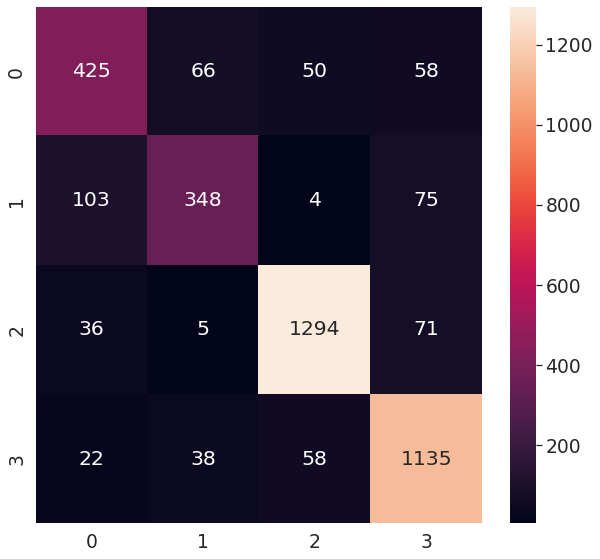

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
mat=confusion_matrix(y_test,cnn_y)
#ax= plt.subplot()
plt.figure(figsize=(10, 9.5))
sns.heatmap(mat, annot=True, fmt = 'd')

In [ ]:
category = pd.get_dummies(df.Emotion)
df_new = pd.concat([df, category], axis=1)

In [ ]:
x = df_new['Text'].values
y = df_new[['happy', 'sadness', 'anger', 'fear']].values

In [ ]:
x

array(['didnt feel humiliated',
       'can from feeling hopeless damned hopeful just from being around someone who cares and awake',
       'grabbing minute post feel greedy wrong', ...,
       'vincent was irritated but not dismay',
       'kendallhume turned back face the dismayed coup',
       'dismayed but not surpris'], dtype=object)

In [ ]:
print(y)

[[0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
x_train.shape

(13532,)

In [ ]:
y_train.shape

(13532, 4)

In [ ]:
x_test.shape

(2145,)

In [ ]:
y_test.shape

(2145, 6)

In [ ]:
x_val.shape

(3861,)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=2000, oov_token='x')
tokenizer.fit_on_texts(x_train) 
tokenizer.fit_on_texts(x_val)
 
sekuens_train = tokenizer.texts_to_sequences(x_train)
sekuens_test = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)
x_test = pad_sequences(x_test)

In [ ]:
import tensorflow as tf
#Adding Dropout 
from tensorflow.keras.layers import Dropout
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=2000, output_dim=16),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#updated

In [ ]:
import tensorflow as tf
#Adding Dropout 
from tensorflow.keras.layers import Dropout
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=2000, output_dim=16),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          32000     
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 2

In [ ]:
y_val.shape

(3863, 6)

In [ ]:
num_epochs = 30
history = model.fit(padded_train, y_train, epochs=num_epochs, batch_size=32,
                    validation_data=(padded_test, y_val))

Epoch 1/30
423/423 [==============================] - 33s 73ms/step - loss: 1.1806 - accuracy: 0.4056 - val_loss: 0.8799 - val_accuracy: 0.5322
Epoch 2/30
423/423 [==============================] - 28s 67ms/step - loss: 0.7950 - accuracy: 0.6373 - val_loss: 0.5540 - val_accuracy: 0.7612
Epoch 3/30
423/423 [==============================] - 30s 72ms/step - loss: 0.5697 - accuracy: 0.7694 - val_loss: 0.4535 - val_accuracy: 0.8549
Epoch 4/30
423/423 [==============================] - 29s 70ms/step - loss: 0.4792 - accuracy: 0.8277 - val_loss: 0.3815 - val_accuracy: 0.8800
Epoch 5/30
423/423 [==============================] - 30s 70ms/step - loss: 0.4071 - accuracy: 0.8613 - val_loss: 0.3143 - val_accuracy: 0.8998
Epoch 6/30
423/423 [==============================] - 29s 69ms/step - loss: 0.3401 - accuracy: 0.8836 - val_loss: 0.2603 - val_accuracy: 0.9137
Epoch 7/30
423/423 [==============================] - 29s 68ms/step - loss: 0.2987 - accuracy: 0.9011 - val_loss: 0.2354 - val_accuracy:

In [ ]:
from tensorflow.keras.models import load_model

model.save("/content/drive/MyDrive/431/LSTM/lstm.h5")
json_string = tokenizer.to_json()

In [ ]:
# evaluate the model
_, train_acc = model.evaluate(padded_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Training Accuracy:",train_acc)
print("Test Accuracy:",test_acc)

Training Accuracy: 0.9651197195053101
Test Accuracy: 0.9319148659706116


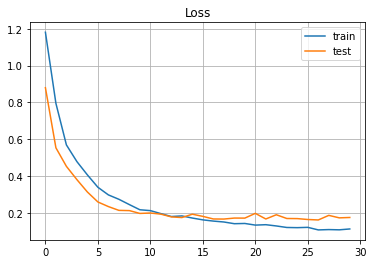

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as pyplot

# plot loss during training
#pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.grid()

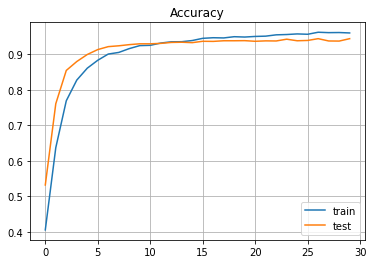

In [ ]:
# plot accuracy during training
#pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.grid()


In [ ]:
predictions=model.predict(x_test,steps=len(x_test), verbose=0)

In [ ]:
import numpy as np
#classes_x=np.argmax(predict_x,axis=1)
y_pred = np.argmax(predictions, axis=-1)
y_true=np.argmax(y_test, axis=-1)

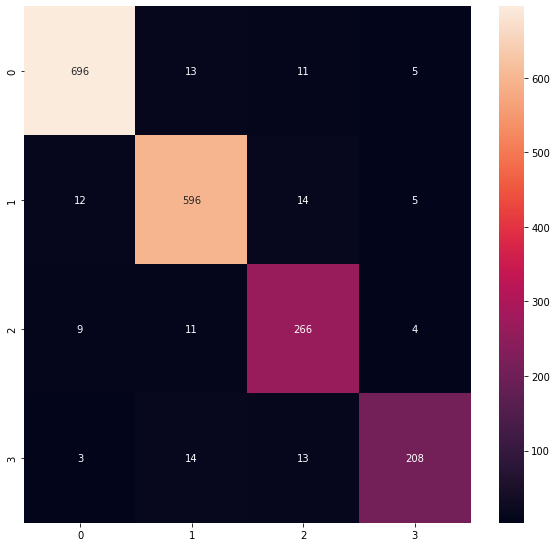

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
mat=confusion_matrix(y_true,y_pred)
#ax= plt.subplot()
plt.figure(figsize=(10, 9.5))
sns.heatmap(mat, annot=True, fmt = 'd')

In [ ]:
from sklearn.metrics import classification_report
target_names = ['0', '1', '2','3']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       725
           1       0.94      0.95      0.95       627
           2       0.88      0.92      0.90       290
           3       0.94      0.87      0.90       238

    accuracy                           0.94      1880
   macro avg       0.93      0.93      0.93      1880
weighted avg       0.94      0.94      0.94      1880



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true,y_pred)

0.9393617021276596